In [16]:
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

In [17]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.WEIGHTS = "/home/abhinavchadaga/CS/fri/output/model_best.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.DATASETS.TEST = "mixed_test"
predictor = DefaultPredictor(cfg)

True

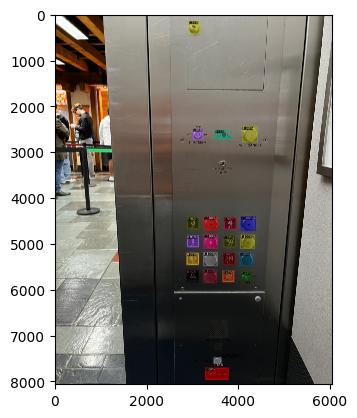

In [18]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from detectron2.utils.visualizer import Visualizer

im = cv2.imread("union - 1.jpeg")
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], scale=2.0)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image())
cv2.imwrite("output.jpg", out.get_image()[:, :, ::-1])